In [1]:
!pip install gym==0.9.4

     |████████████████████████████████| 163kB 3.4MB/s 
  Created wheel for gym: filename=gym-0.9.4-cp36-none-any.whl size=215483 sha256=5d7750add050f782d557fb50af23a18db8c53df00f676e26418cc7b0a0769882
  Stored in directory: /root/.cache/pip/wheels/2f/ae/a0/126678adc5f1f8905309a4712ea29537999787f610edbcb0a4
Successfully built gym
ERROR: dopamine-rl 1.0.5 has requirement gym>=0.10.5, but you'll have gym 0.9.4 which is incompatible.
  Found existing installation: gym 0.17.1
    Uninstalling gym-0.17.1:
      Successfully uninstalled gym-0.17.1


In [0]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler


# ST449 Final Project
## --Financial portfolio managment using deep reinforcement learning<br>

### Introduction 
Financial portfolio management is a process of efficiently redistributing limited availability of funds into different financial products, aiming to maximize the return while restraining the risk (Haugen, 1986; Markowitz, 1968).<br>

Traditional ways of managing portfolios involve analyzing market trends and performance of individual entities while acting timely to any external shocks. This requires a huge amount of human supervision. It usually takes a whole team to act around the clock. On contrast, algorithmic trading uses machines to watch over the market movement. Under the economic assumption that current prices perfectly reveals any available market information, machines could learn to react to the signals revealed in price and perform automatically.<br>

### Problem definition
Deep Reinforcement Learning(RL) is lately drawing much attention due to its remarkable achievements in playing video games (Mnih et al., 2015) and board games (Silver et al., 2016).
Reinforcement learning can be seen as a model-free approach to algorithmic trading. Comparing to the conventional approach where the action is determined based on the predicted price, RL can learn from a pattern and decide based on the states and actions hence avoiding risk in false prediction. 
In this project, deep reinforcement learning is achieved by a neural-network approximated action policy function, and a second network is trained as the reward function estimator. 
In terms of the financial market, in this paper, we only look at the foreign exchange(FX) market and the cryptocurrency market. <br>
The FX market has the following desired properties:
1. High liquidity.
The FX market is the most liquid financial market in the world. This ensures that trades are executed without affecting the market price. This is desirable for algorithmic trading when scaling the investment, ensuring the algorithm could still output a consistent level of return.

2. Low trading cost.
The FX market has a very low trading cost comparing to outer financial markets. There is no commission charged, the only cost is the gap between buying and selling price. In algorithmic trading, when the machine makes frequent trades, transaction costs could affect investment profitability to a large extent.

3. Continuous trading market.
The FX market opens 24/7 without restricting the frequency of tradings. A non-stop market is ideal for machines to learn in the real world in shorter time-frames.

The cryptocurrency market also has the desired property of a continuous trading market and low trading cost. Some well-known algorithmic trading company has already entered the crypto market such as Tower research, Jump Trading, and Citadel.

A portfolio makes up of FX, Crypto, and cash can be traded smoothly at any day hence ideal for implementing an algorithmic trading environment.

### Assumption/ hypotheses
Some reasonable assumptions to be made for the framework for simplicity. Further work can be carried out for a more realistic model to reflect the real-world trading environment.
1. Zero slippage: The liquidity of all assets is high enough that each trade can be carried out at the last price.
2. Zero market impact: The capital invested by the machine is insignificant that it does not influence the market.
3. No trading cost: No commission, Bid-Ask Spread negligible.


### Data preprocessing, assets pre-selection
In the experiments of this paper, Japanese yan to USD (JPY/USD) is selected as it is one of the most frequently traded pairs. The second asset in this portfolio is Bitcoin (BTC/USD) as it is the largest in trading volume in crypto. Price history is obtained from Quora(BTC) and Yahoo Finance (JPY). Both prices are measured in USD. Price history is rounded up to integers to reduce the state space. In the real world, roundings should be omitted for a more realistic model and accurate measure.

From the plotted data below, the red line refers to BTC and the blue line represents JPY, noticing the two trading pair does not share the same Y-axis and the range for JPY( 125 - 100 = 25 ) is much smaller comparing to that of BTC ( 20000 - 0 = 20000). Hence it is easy to see that JPY is less volatile compared to BTC which makes JPY an ideal diversification asset to pair with BTC.

In [0]:
def get_data(col='Last'):
  """ Returns a 2 x n_day array """
  btc = pd.read_csv('./btc.csv', usecols=[col])
  jpy = pd.read_csv('./jpy.csv', usecols=[col])
  
   # round up to integer to reduce state space
  return np.array([np.around(btc[col].values), np.around(jpy[col].values[:len(btc)])])

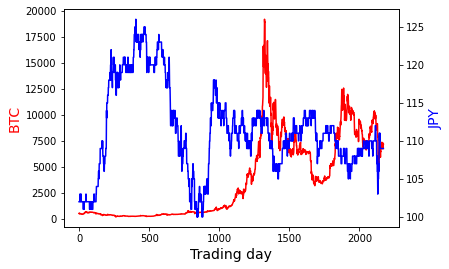

BTC price variance: 15345321.578148475JPY price variance: 33.36048960654437


In [8]:
data_ = get_data()

fig,ax = plt.subplots()
ax.plot(range(len(data_[0])),data_[0], color="red")
ax.set_xlabel("Trading day",fontsize=14)
ax.set_ylabel("BTC",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(range(len(data_[0])),data_[1],color="blue")
ax2.set_ylabel("JPY",color="blue",fontsize=14)
plt.show()
print('BTC price variance: ' + str(np.var(data_[0]))+ 'JPY price variance: ' + str(np.var(data_[1])) )

A scaler is used to normalize the price to the 0-1 range (feature scaling). This helps to speed up the convergence of gradient.

In [0]:

def get_scaler(env):
  """ Takes a env and returns a scaler for its observation space """
  low = [0] * (env.n_asset * 2 + 1)
  high = []
  max_price_ls = env.price_history.max(axis=1)
  min_price_ls = env.price_history.min(axis=1)
  max_cash_tri = env.initial_value * 3 
  max_asset_owned = max_cash_tri // min_price_ls
  for i in max_asset_owned:
    high.append(i)
  for i in max_price_ls:
    high.append(i)
  high.append(max_cash_tri)

  scaler = StandardScaler()
  scaler.fit([low, high])
  return scaler


def maybe_make_dir(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)

## Trading environment
The environment follows from gym space. For each trading day, the following are parameters are recorded: the number of stocks owned on that day, the price of each stock, and any cash available in hand. The number of the state is hence 2* n. asset +1. In the case where 2 assets in the portfolio, the total number of states is 5.
Trade is executed once every day using the 'Last' price of each currency. When an action is determined by the network \[sell(0), hold(1), or buy(2)\], if a buy decision is picked, iterate through the currencies, buy a unit of the currency and then move on to the next currency. This ensures an even allocation of the cash available. However, in the real world, it is more realistic to have a specific weight trained for each target asset and distribute the fund available in a more dynamic allocation to increase the efficiency of the fund. But for simplicity here, the machine will continue to buy units of currency until there is no more cash available. If the action signals a sell to be executed then the machine will sell all stock in the portfolio in return for cash. The rationale of this action can be interpreted as buying as much as possible if knowing the price of tomorrow is likely to be high and vise versa and it will yield the maximum portfolio value. 

During each trade, an action is determined with an epsilon greedy policy, that is with probability epsilon, the machine will follow the action output from the neural network, otherwise, the machine will pick a random action from the action place as an exploration. An epsilon greedy policy eventually performed better because it continued to explore and to improve its chances of recognizing the optimal action. The value of epsilon is set at a decaying rate so that the network is less explorative over time, as the network might have come close to the optimal action already.





In [0]:
import gym
from gym import spaces
from gym.utils import seeding


class TradingEnv(gym.Env):
 
  def __init__(self, feed_data, initial_value):
    '''Input data of price history and an initial amount of investment. '''
    self.price_history = np.round(feed_data,3)
    self.n_asset, self.n_day = self.price_history.shape

    # instance attributes
    self.initial_value = initial_value 
    self.current_day = None #current day starting from 0
    self.asset_owned = None #asset bought
    self.asset_price = None #price of asset
    self.cash_in_hand = None #cash

    # action space
    self.action_space = spaces.Discrete(3*self.n_asset) 

    # observation space: give estimates in order to sample and build scaler 
    #each gives a range starting from 0  
    asset_max_price = self.price_history.max(axis=1)
    asset_range = [[0, initial_value * 2 // mx] for mx in asset_max_price]
    price_range = [[0, mx] for mx in asset_max_price]
    cash_in_hand_range = [[0, initial_value * 2]]
    self.observation_space = spaces.MultiDiscrete(asset_range + price_range + cash_in_hand_range)
    #observation_space.shape =2+2+1 = 5 dim array corresponding to the three range above
    #print(asset_range + price_range + cash_in_hand_range)

    # seed and start
    self._seed()
    self._reset()


  def _seed(self, seed=None):
    '''Set seed'''
    self.np_random, seed = seeding.np_random(seed)
    return [seed]


  def _reset(self): 
    '''Reset to day 0, with initial value all in cash, 0 asset owned'''
    self.current_day = 0
    self.asset_owned = [0] * self.n_asset
    self.asset_price = self.price_history[:, self.current_day]
    self.cash_in_hand = self.initial_value
    return self._get_obs()


  def _step(self, action): 
    '''Perform 1 trade per day, follows from gym'''
    assert self.action_space.contains(action)
    prev_val = self._get_val()
    self.current_day += 1
    self.asset_price = self.price_history[:, self.current_day] # update price
    self._trade(action)
    current_value = self._get_val()
    reward = current_value - prev_val
    done = self.current_day == self.n_day - 1 #end on second last day
    info = {'current_value': current_value}
    return self._get_obs(), reward, done, info


  def _get_obs(self):
    '''Return 5 dim array of the portfolio current account. '''
    obs = []
    obs.extend(self.asset_owned) 
    obs.extend(list(self.asset_price))
    obs.append(self.cash_in_hand)
    return obs 


  def _get_val(self): 
    '''Calculate net worth including assets and cash. '''
    return np.sum(self.asset_owned * self.asset_price) + self.cash_in_hand


  def _trade(self, action): 
    '''All trading action combo: sell(0), hold(1), or buy(2) assets.'''
    action_combo = list(map(list, itertools.product([0, 1, 2], repeat=self.n_asset)))
    action_vec = action_combo[action]
 
    #First to get sell/buy index
    sell_index = []
    buy_index = []
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    #Secondly, sell first, then buy; a naive settings but compromise for coding here 
    if sell_index:
      for i in sell_index:
        self.cash_in_hand += self.asset_price[i] * self.asset_owned[i]
        self.asset_owned[i] = 0
    if buy_index:
      cash_true = True
    #If amount of cash in hand is enough to buy more asset then keep buying one asset at a time
    #buy approximately equal amount of number of assets across assets
    
      while cash_true:
        for i in buy_index:
          if self.cash_in_hand > self.asset_price[i]:  
            self.asset_owned[i] += 1 # buy one unit
            self.cash_in_hand -= self.asset_price[i]
          else: 
            cash_true = False

### Q network
Here are the three neural networks structures: 
1. Multi-layer perceptron(MLP) <br>

MLP is the classical type of neural network. Made up of one or more layers of neurons. Data is fed to the input layer, there may be one or more hidden layers providing levels of abstraction, and predictions are made on the output layer.
MLPs are suitable for classification prediction problems where inputs are assigned a class or label. It is also suitable for regression prediction problems where a real-valued quantity is predicted given a set of inputs. MLP is very flexible and can be used to learn a mapping from inputs to outputs. The results can be used as a baseline point of comparison to confirm that other models that may appear better-suited. <br>
For the MLP model used here, the input is in the shape of (batch size, number of states). Passing through a total of 4 layers, each layer with an increasing number of neurons. At the end of each layer, the relu activation function is performed on the output from the previous layer f(x) = max(0, x). That is any negative input will be interpreted as 0 and linear for positive input. Relu increases the non-linear feature of the neural network, resolving the problem of vanishing gradient.
During training, batch normalization is performed after each dense layer. Normalizing the inputs of each layer to overcome the internal covariate shift problem.
During testing, the mean and the variance are fixed. They are estimated using the previously calculated means and variances of each training batch.


2. Convolution neural network(CNN)<br>

CNN is designed to map image data to an output variable. CNN is proven effective for any type of prediction problem involving image data as an input. Generally, CNNs work well with data that has a spatial relationship.
The CNN input is traditionally 2-D but can also be changed to be 1-D, allowing it to develop an internal representation of a 1-D sequence which is ideal for this paper. The input of history price can be viewed as a 1-D array, the length is the number of observation.

Although not specifically developed for non-image data, CNN still achieve the state-of-the-art result on problems such as time-series prediction which is proven in the result of this paper.<br>

For the CNN model used here, the input is in the shape(batch size, numb. of feature, image height, image width) which numb of feature is 1, height is 1, width is numb of states.
The input is first passed through a Conv1D layer. The difference between a Conv1D and Conv2D layer is that for Conv1D, a filter of size 7 contains only 7 vectors. Whereas in a 2D CNN, a filter of size 7 will contain 49 feature vectors, making it a very broad selection. The output is then passed on to a maxpooling1D layer which performs maxpooling within the 1D array.

3. Bidirectional Long Short Term Memory(Bi-LSTM)<br>

Recurrent Neural Networks, or RNNs, were designed to work with sequence prediction problems.

Sequence prediction problems come in many forms and are best described by the types of inputs and outputs supported. The Long Short-Term Memory, or LSTM, network is perhaps the most successful RNN because it overcomes the problems of training a recurrent network and in turn has been used on a wide range of applications. RNNs in general and LSTMs, in particular, have received the most success when working with sequences of words and paragraphs, generally called natural language processing. As price prediction is also considered as a time-series prediction, using LSTM for predicting actions in portfolio management seems reasonable hence using LSTM here for a comparison of the result.

#### Optimizer, Learning rate, Loss function
* The optimizer used is Adam with an exponentially decaying learning rate. Adam is considered as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of the gradient itself like SGD with momentum. 
* An exponentially decaying learning rate is used for faster convergence. The learning rate is big at the beginning of training, as time increases, the network comes closer to the optimal weight, a smaller learning rate avoids missing the optimal point. 
* Using MSE as the loss function which measures the squared difference between the prediction and the true value.

In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
def mlp(n_obs, n_action, training = False, n_hidden_layer=3, n_neuron_per_layer=[32,64,128],
        activation='relu', loss='mse'): 

  inputs = tf.keras.Input(shape=(n_obs))
  
  x = layers.Dense(16, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l=0.01), bias_regularizer=tf.keras.regularizers.l2(l=0.01))(inputs)
  x = layers.BatchNormalization()(x,training = training)
  for _,n in zip(range(n_hidden_layer),n_neuron_per_layer):
    x = layers.Dense(n, activation=activation)(x)
    x = layers.BatchNormalization()(x,training = training)
  
  outputs = layers.Dense(n_action, activation='linear')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs )

  model.compile(loss=loss, optimizer=optimiser)
  print(model.summary())
  return model


def cnn_cell(n_obs, n_action,training = False, n_hidden_layer=3, activation='relu', loss='mse'):
   
  inputs = tf.keras.Input(shape=(10,n_obs))
  x = layers.Conv1D(32, 3, padding='same', activation=activation)(inputs)
  x = layers.MaxPooling1D(2)(x)
  x = layers.BatchNormalization()(x,training = training)
  x = layers.Conv1D(64, 3,padding='same',  activation=activation)(x)
  x = layers.MaxPooling1D(2)(x)
  x = layers.BatchNormalization()(x,training = training)

  outputs = layers.Dense(n_action, activation='linear')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(loss=loss, optimizer=optimiser)
  print(model.summary())
  return model

def LSTM_cell(n_obs, n_action,training = False,n_hidden = 10, activation='relu', loss='mse'):

  inputs = tf.keras.Input(shape=(n_obs,1,))
  x = layers.Bidirectional(layers.LSTM(n_hidden, return_sequences=True,recurrent_dropout=0.1))(inputs)
  x = layers.BatchNormalization()(x,training = training)
  outputs = layers.Dense(n_action, activation='linear')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.compile(loss=loss, optimizer=optimiser)
  print(model.summary())
  return model




## Deep Q agent

In our deep Q-learning framework, the Q network is the above CNN, MLP and LSTM.

Q-learning updates action value estimates using the values of the next state-action pairs where the actions are generated by a greedy policy. Here the policy is set at a exploration rate epsilon = 0.95.
Using experience replay, memory M to store each transition (s, a, r, s') as it is used in an episode, after which we sample a mini-batch of transitions from the memory and then minimize the loss function
Experience replay is developed to overcome the problem of correlated data and non-stationary distribution. The advantage of experience replay is the high efficiency usage of data as a sample  could be selected multiple times. Another advantage is that randomly sampled data could reduce the variance in continuous correlated sample.
We approximate the target 
<img src="Q_reward.png">
And perform a gradient descent step on (Q' - Q)^2 with respect to network parameters. 

In [0]:
from collections import deque
import random


class DQNAgent(object):
  """ A simple Deep Q agent """
  def __init__(self, state_size, action_size,training=False,model_ = None):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = deque(maxlen=2000)
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    if model_ =='MLP':
      self.model = mlp(state_size, action_size,training = False)
    elif model_ == 'CNN':
      self.model = cnn_cell(state_size, action_size,training = False)
    else:
      self.model = LSTM_cell(state_size, action_size,training = False)
  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))


  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return random.randrange(self.action_size)
    act_values = self.model.predict(state)
    return np.argmax(act_values[0])  # returns action


  def replay(self, batch_size=32):
    """ vectorized implementation; 30x speed up compared with for loop """
    minibatch = random.sample(self.memory, batch_size)

    states = np.array([tup[0][0] for tup in minibatch])
    actions = np.array([tup[1] for tup in minibatch])
    rewards = np.array([tup[2] for tup in minibatch])
    next_states = np.array([tup[3][0] for tup in minibatch])
    done = np.array([tup[4] for tup in minibatch])

    # Q(s', a)
    target = rewards + self.gamma * np.amax(self.model.predict(next_states), axis=1)
    # end state target is reward itself (no lookahead)
    target[done] = rewards[done]

    # Q(s, a)
    target_f = self.model.predict(states)
    # make the agent to approximately map the current state to future discounted reward
    target_f[range(batch_size), actions] = target
    
    self.model.fit(states, target_f, epochs=5, verbose=0)
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay
    

  def load(self, name):
    self.model.load_weights(name)


  def save(self, name):
    self.model.save_weights(name)

## Performance measures<br>
Here we measure in terms of portfolio return which is the percentage change in portfolio value at the end of the period.<br>
Another measure is the Sharpe ratio. In finance, the Sharpe ratio measures the performance of an investment compared to a risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment. (Wikipedia) <br>
When analyzing the Sharpe ratio, the higher the value, the more excess return investors can expect to receive for the extra volatility they are exposed to by holding a riskier asset.  

In [0]:
def portfolio_return(portfolio_value, initial_value):
  x = (np.mean(portfolio_value)-initial_value)/initial_value
  return x

def sharpe_ratio(portfolio_return,r_f,port_std):
  S = (portfolio_return - r_f)/port_std
  return S


The portfolio is set to have an initial value of 200,000USD. And using the first 1500 trading day price history as training data. Set experience replay once memory exceeds the batch size 32. 

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_83 (Dense)             (None, 16)                96        
_________________________________________________________________
batch_normalization_79 (Batc (None, 16)                64        
_________________________________________________________________
dense_84 (Dense)             (None, 32)                544       
_________________________________________________________________
batch_normalization_80 (Batc (None, 32)                128       
_________________________________________________________________
dense_85 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_81 (Batc (None, 64)                256

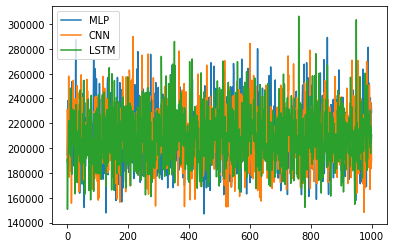

In [52]:
import pickle
import time
import numpy as np
import re
##train:
initial_value = 200000
episode = 1000
batch_size = 32
train_dict = dict()
maybe_make_dir('weights')
maybe_make_dir('portfolio_val')

data = get_data() 
train_data = data[:, :1500] #split data for training and testing

for model_ in ['MLP','CNN','LSTM']: 

  env = TradingEnv(train_data, initial_value)
  state_size = env.observation_space.shape
  action_size = env.action_space.n
  agent = DQNAgent(state_size, action_size,training = True, model_ = model_)
  scaler = get_scaler(env)
  portfolio_value = []

  for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])#get back the normalized state
    for time in range(env.n_day):
      action = agent.act(state)
      next_state, reward, done, info = env.step(action)
      next_state = scaler.transform([next_state])
      agent.remember(state, action, reward, next_state, done) #store 1 frame
      state = next_state
      if done:
        
        print("episode: {}/{}, episode end value: {}".format(
          e + 1, episode, info['current_value']))
        portfolio_value.append(info['current_value']) # append episode end portfolio value
        break
        if len(agent.memory) > batch_size: 
          #when the amount of stored frame is enough for one batch, replay
          agent.replay(batch_size)

  
    if (e + 1) % 10 == 0:  # checkpoint weights
      agent.save('weights/{}-dqn.h5'.format(model_))
  port_mean = np.mean(portfolio_value)
  port_std = np.std(portfolio_value)
  port_return = portfolio_return(portfolio_value, initial_value)
  r_f = 0
  train_dict.setdefault(model_,[]).append((port_mean, port_std, round(port_return,2) *100,sharpe_ratio(port_return,r_f,port_std)))
  
  plt.plot(portfolio_value,label = model_)
  plt.legend(loc="upper left")
  # save portfolio value history 
  with open('portfolio_val/{}-{}.p'.format(model_, 'train'), 'wb') as fp:
    pickle.dump(portfolio_value, fp)

plt.show()


In [53]:
train_dict

{'CNN': [(209346.285, 22365.141295278576, 5.0, 2.089475956490618e-06)],
 'LSTM': [(208948.237, 22197.954824191147, 4.0, 2.0155543767140834e-06)],
 'MLP': [(209379.247, 22580.693552678822, 5.0, 2.076828813543531e-06)]}

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_90 (Dense)             (None, 16)                96        
_________________________________________________________________
batch_normalization_86 (Batc (None, 16)                64        
_________________________________________________________________
dense_91 (Dense)             (None, 32)                544       
_________________________________________________________________
batch_normalization_87 (Batc (None, 32)                128       
_________________________________________________________________
dense_92 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_88 (Batc (None, 64)                256

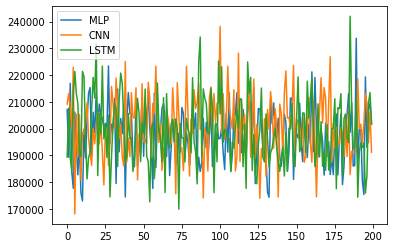

In [54]:
initial_value = 200000
episode = 200
batch_size = 32
 
maybe_make_dir('weights')
maybe_make_dir('portfolio_val')
test_dict = dict()

test_data = data[:, 1500:] 
for model_ in ['MLP','CNN','LSTM']:
  env = TradingEnv(train_data, initial_value)
  state_size = env.observation_space.shape
  action_size = env.action_space.n
  agent = DQNAgent(state_size, action_size, training = False, model_ = model_)
  scaler = get_scaler(env)

  portfolio_value = []

  # remake the env with test data
  env = TradingEnv(test_data, initial_value)
  # load trained weights
  agent.load('/content/weights/{}-dqn.h5'.format(model_))
  

  for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for time in range(env.n_day):
      action = agent.act(state)
      next_state, reward, done, info = env.step(action)
      next_state = scaler.transform([next_state])

      agent.remember(state, action, reward, next_state, done)
      state = next_state
      if done:
        print("episode: {}/{}, episode end value: {}".format(
            e + 1, episode, info['current_value']))
        portfolio_value.append(info['current_value']) 
        break
  port_mean = np.mean(portfolio_value)
  port_std = np.std(portfolio_value)
  port_return = portfolio_return(portfolio_value, initial_value)
  r_f = 0
  test_dict.setdefault(model_,[]).append((port_mean, port_std, round(port_return,2) *100,sharpe_ratio(port_return,r_f,port_std)))
  plt.plot(portfolio_value,label = model_)
  plt.legend(loc="upper left")

  with open('portfolio_val/{}-{}.p'.format(model_, 'test'), 'wb') as fp:
    pickle.dump(portfolio_value, fp)

plt.show()



In [55]:
test_dict

{'CNN': [(200720.495, 11677.522757844446, 0.0, 3.084965086092418e-07)],
 'LSTM': [(198964.965, 12742.01390965239, -1.0, -4.0615047485387644e-07)],
 'MLP': [(197766.385, 10844.52112713028, -1.0, -1.0298356994353786e-06)]}

### Results<br>

From the performance output of the training set, the CNN and MLP performed better in terms of returns(5%) and in between these two, CNN was able to reach the same level of return with a smaller variance(22365 < 22580). In the real world, a low portfolio variance is preferred compared to a more volatile one. <br> 
However, the machine was performing less efficiently when dealing with the testing data. The CNN model was able to perform on average breaking even and a positive Sharpe ratio but the other two models were making a loss with negative Sharpe ratios.

### Conclusion<br>
To recap on the model used in this research, we use a deep learning agent with a neural network as the Q network to generate actions, while the model learns from the past price history and output actions indicating trading decisions. And perform trading according to the decisions made and continuously feedback the reward obtained from performing such action so the machine continues to learn to make trading decisions that will give a higher return. This model is only a simplified version of real-world trading and a lot more parameters could be added for a more realistic and applicable trading robot. Such as adding more price features, including the highest price of the day, sentiment analysis of the asset-related news, and in the real world, the trading interval can be as small as 0.01s. Trading cost such as commissions also needs to be included for high-frequency trading. But comparing the three neural network used in this paper, CNN still outperformed the other two.

### Reference<br>
Deep Reinforcement Learning for Portfolio Management
Chi Zhang, Corey Chen, Limian Zhang http://www-scf.usc.edu/~zhan527/post/cs599/ <br>

A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem https://arxiv.org/abs/1706.10059